In [1]:
%matplotlib inline
import pandas as pd
import csv
import dateutil
import numpy as np
import pytz
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib

In [2]:
LOCAL_TZ = pytz.timezone('CET')
matplotlib.rcParams['timezone'] = 'CET'
plt.rcParams["figure.figsize"] = (7,3)

# Analyze activation data from Controller logs and CouchDB

In [3]:
# File generated from controller's log and Couch DB database by ../tools/activation_stats.py --controller-log controller0.log --output controller0.csv.gz --lookup-activations
activation_stats = pd.read_csv('controller0.csv.gz', index_col=0, low_memory=False,
                               dtype={'timeout': 'boolean', 'scheduled': str, 'action': str, 'invoker': str, 'kafka_send': str, 'received_result': str, 'status': str})

In [4]:
gatling_activations = activation_stats[activation_stats.action.fillna('').str.startswith('guest/sleep_10ms')].copy() # Gatling load
for c in ('scheduled', 'kafka_send', 'received_result'): #, 'lb_start'):
    gatling_activations[c] = pd.to_datetime(gatling_activations[c]).dt.tz_convert(LOCAL_TZ)
gatling_activations['status'].fillna('timeout', inplace=True)
gatling_activations['status'].replace(['action developer error'], ['failed during execution'], inplace=True)

In [5]:
gatling_activations['scheduled_start_slot'] = gatling_activations['scheduled'].apply(lambda t: t.replace(second=0, microsecond=0))

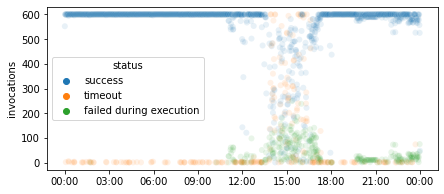

In [6]:
def plot_activation_stats(df, fn=None):
#         plt.figure(grp)
    agg_df = df.groupby(['scheduled_start_slot', 'status']).agg(invocations=pd.NamedAgg('activation_id', 'count')).reset_index()
    ax = sns.scatterplot(data=agg_df, x='scheduled_start_slot', y='invocations', hue='status', alpha=0.1,
                         hue_order=['success', 'timeout', 'failed during execution'])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.tick_params(axis='x', rotation=0)
    ax.set_xlabel('')
    if fn:
        plt.tight_layout()
        plt.savefig(fn, metadata={'CreationDate': None})
        plt.close()

plot_activation_stats(gatling_activations)

In [7]:
plot_activation_stats(gatling_activations, fn='01 - Fib model analysis - Gatling load.pdf')

In [8]:
TOTAL_GATLING_REQUESTS = 10 * 3600 * 24
pd.Series({
    'records': len(gatling_activations) / TOTAL_GATLING_REQUESTS,
    'success': len(gatling_activations.query('status == "success"')) / len(gatling_activations),
    'timeout': len(gatling_activations.query('status == "timeout"')) / len(gatling_activations),
    'action developer error': len(gatling_activations.query('status == "failed during execution"')) / len(gatling_activations)
})

records                   0.952940
success                   0.951923
timeout                   0.031556
action developer error    0.016522
dtype: float64

# Analyze Gatling report

In [9]:
def load_gatling_report(fn):
    data = []
    with open(fn) as f:
        for line in csv.reader(f, delimiter='\t'):
            if line[0] == 'REQUEST':
                data.append({'req_duration': int(line[4]) - int(line[3]), 'begin': int(line[3]), 'end': int(line[4]), 'func': line[2], 'status': line[5], 'reason': line[6]})
    return pd.DataFrame(data=data)

def gatling_stats(df):
    diff = df['end'] - df['begin']
    return pd.Series({
        'min_time': diff.min(),
        'median': diff.median(),
        'avg': diff.mean(),
        'p75': np.percentile(diff, 75),
        'p90': np.percentile(diff, 90),
        'p95': np.percentile(diff, 95),
    })
    
gatling_report = load_gatling_report('simulation.log')

In [10]:
gatling_stats(gatling_report.query('status=="OK"'))

min_time       24.000000
median        865.000000
avg         11307.510479
p75          1678.000000
p90         60021.000000
p95         60022.000000
dtype: float64